In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv', sep=',',header=None)
data = data.iloc[::-1]
amzn = data[0].to_numpy()[:-1].astype(np.float64)
td = data[1].to_numpy()[:-1].astype(np.float64)
tsla = data[2].to_numpy()[:-1].astype(np.float64)
googl = data[3].to_numpy()[:-1].astype(np.float64)

portfolio= [amzn, td, tsla, googl]

log_returns = np.array([-np.diff(np.log(stock)) for stock in portfolio])

investment = 1e6

weights = np.array([[1/4]*4]) 

confidence = [0.97, 0.95, 0.99]





In [2]:
def varcovar_method(portfolio,weights, investment, confidence):
    #mean
    mean_returns = portfolio.mean(1)
    #covariance matrix
    sigma_log_returns = np.cov(np.array(portfolio))
    #weighted returns
    p_mean = np.dot(weights,mean_returns)
    #weighted std
    p_sigma = np.sqrt(np.matmul(np.matmul(weights, sigma_log_returns),weights.T))
    #sampling from normal cdf
    confidence_icdf = norm.ppf(confidence)
    
    #var and ES calculations
    VaR = float(investment*(-p_mean + p_sigma*confidence_icdf))
    ES = float(investment*(-p_mean + p_sigma*norm.pdf(confidence_icdf)/(1-confidence)))                 
    return VaR, ES    

In [4]:
var =[0,0,0]
es =[0,0,0]

for i in range(3):
    var[i],es[i] = varcovar_method(log_returns,weights, investment, confidence[i])
    
es1 = es[0]
es2 = 0.5*(es[1]+es[2])

print(es2-es1)

1574.5669146573491


In [3]:
def historic_method(portfolio,weights, investment, confidence):
    #weighted portfolio change
    p = np.matmul(portfolio.T,weights.T).T
    #losses are negative gains
    losses = -investment*p
    #quantile function 
    VaR = np.quantile(losses, confidence)
    #amount of times loss was greater than VaR 
    cond_losses = [loss for loss in losses[0] if loss > VaR]
    #mean of losses past VaR
    ES = np.mean(cond_losses)
    
    return VaR, ES

In [4]:
def montecarlo_method(portfolio,weights, investment, confidence):
    confidence_icdf = norm.ppf(confidence)
    mean_returns = portfolio.mean(1) 
    sigma_log_returns = np.cov(portfolio)
    p_mean = np.dot(weights,mean_returns)
    p_sigma = np.sqrt(np.matmul(np.matmul(weights, sigma_log_returns),weights.T))
    samples = np.random.normal(-investment*p_mean, investment*p_sigma,int(1e5))
    VaR = np.quantile(samples, confidence)
    cond_losses = [loss for loss in samples if loss > VaR]
    #mean of losses past VaR
    ES = np.mean(cond_losses)
    return VaR, ES

In [5]:
def rolling_window(data, window,function,weights, investment, confidence,varlog, eslog):
    for horizon in range (data.shape[1]-window):
        sample = data[:,horizon:horizon+window]
        func_data = function(sample,weights, investment, confidence)
        varlog.append(func_data[0])
        eslog.append(func_data[1])

In [6]:
#var covar results

window = 252
var_covar,es_covar =[[],[],[]],[[],[],[]]


for i in range(3):
    for horizon in range (log_returns.shape[1]-window):
        sample = log_returns[:,horizon:horizon+window]
        var,es = varcovar_method(sample,weights, investment, confidence[i])
        var_covar[i].append(var)
        es_covar[i].append(es)
    var_covar[i].reverse()
    es_covar[i].reverse()

In [7]:
#historic results

var_hist,es_hist =[[],[],[]],[[],[],[]]


for i in range(3):
    for horizon in range (log_returns.shape[1]-window):
        sample = log_returns[:,horizon:horizon+window]
        var,es = historic_method(sample,weights, investment, confidence[i])
        var_hist[i].append(var)
        es_hist[i].append(es)
    var_hist[i].reverse()
    es_hist[i].reverse()        


In [8]:
#montecarlo results

var_MC,es_MC =[[],[],[]],[[],[],[]]


for i in range(3):
    for horizon in range (log_returns.shape[1]-window):
        sample = log_returns[:,horizon:horizon+window]
        var,es = montecarlo_method(sample,weights, investment, confidence[i])
        var_MC[i].append(var)
        es_MC[i].append(es)
    var_MC[i].reverse()
    es_MC[i].reverse()        


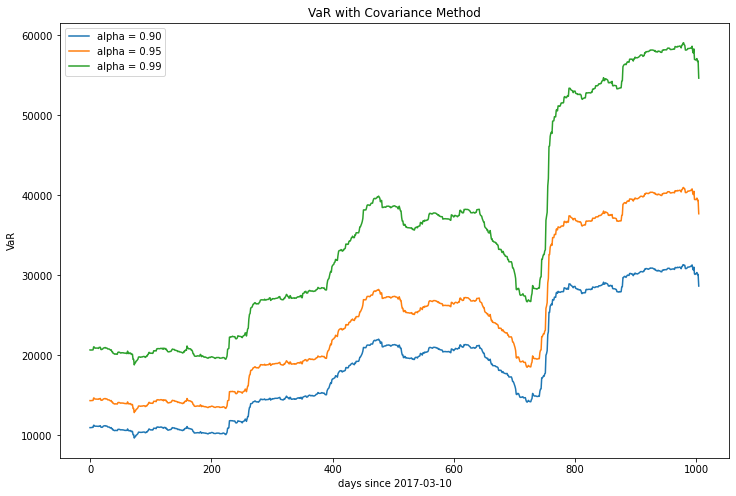

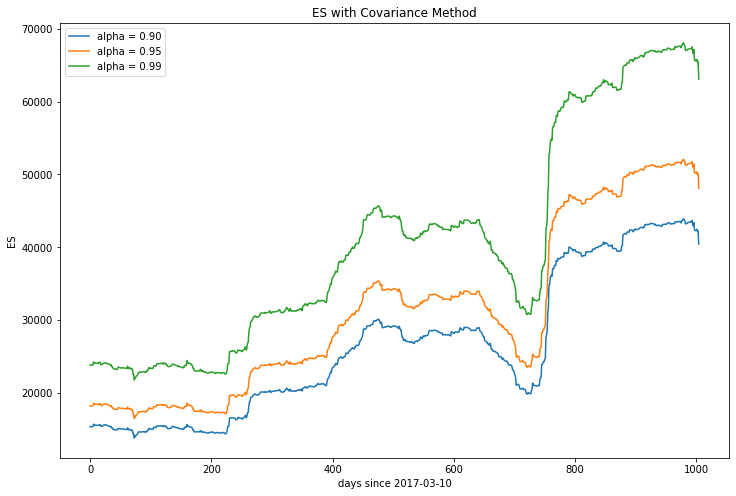

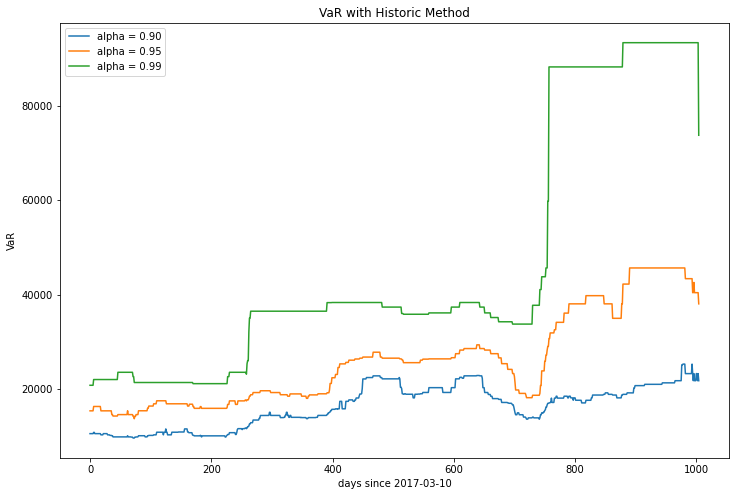

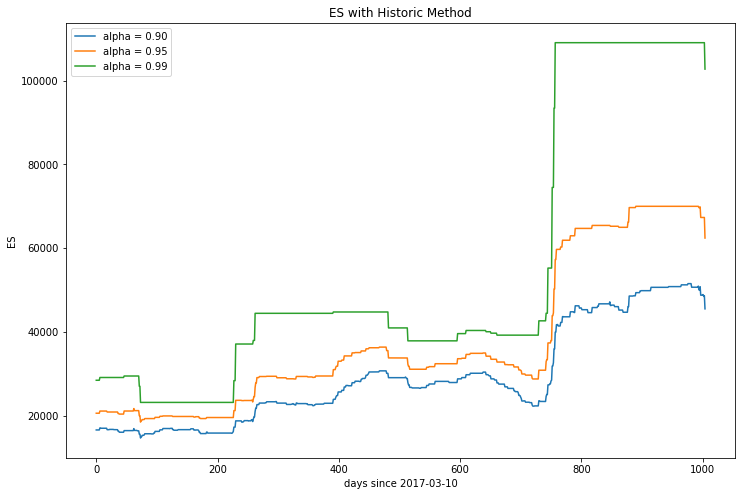

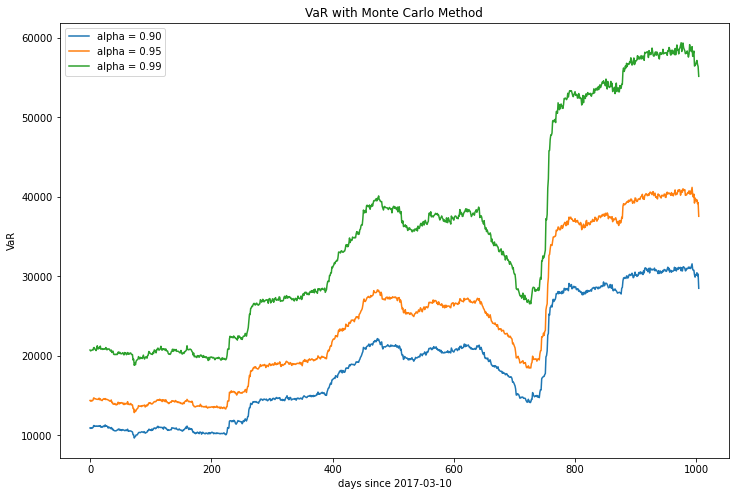

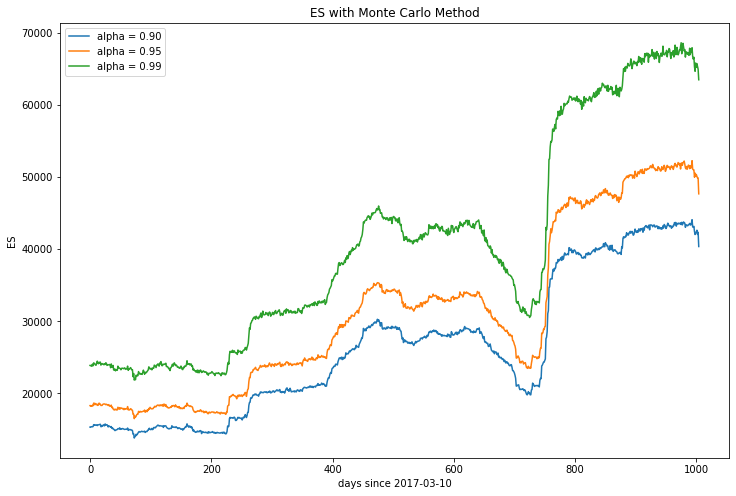

In [19]:
methods =['Covariance', 'Historic', 'Monte Carlo']
VaR_list = [var_covar,var_hist,var_MC]
ES_list = [es_covar,es_hist,es_MC]
legends = ['alpha = 0.90','alpha = 0.95','alpha = 0.99']

for plots in range(3):
    current_var = VaR_list[plots]
    current_es = ES_list[plots]
    plt.figure(figsize=(12,8))
    plt.plot(current_var[0])
    plt.plot(current_var[1])
    plt.plot(current_var[2])
    plt.legend(legends)
    plt.title('VaR with {} Method'.format(methods[plots]))
    plt.xlabel('days since 2017-03-10')
    plt.ylabel('VaR')
#     plt.savefig('VaR with {} Method.png'.format(methods[plots]))
    plt.show()
    

    plt.figure(figsize=(12,8))
    plt.plot(current_es[0])
    plt.plot(current_es[1])
    plt.plot(current_es[2])
    plt.legend(legends)
    plt.title('ES with {} Method'.format(methods[plots]))
    plt.xlabel('days since 2017-03-10')
    plt.ylabel('ES')
#     plt.savefig('ES with {} Method.png'.format(methods[plots]))
    plt.show()
    

In [20]:
#var covar results

window = round(252/2)
var_covar_half,es_covar_half =[[],[],[]] , [[],[],[]]


for i in range(3):
    for horizon in range (log_returns.shape[1]-window):
        sample = log_returns[:,horizon:horizon+window]
        var,es = varcovar_method(sample,weights, investment, confidence[i])
        var_covar_half[i].append(var)
        es_covar_half[i].append(es)
    var_covar_half[i].reverse()
    es_covar_half[i].reverse()

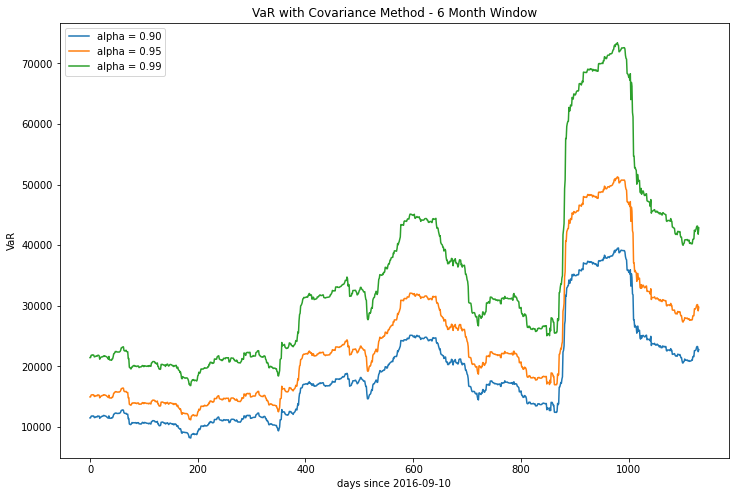

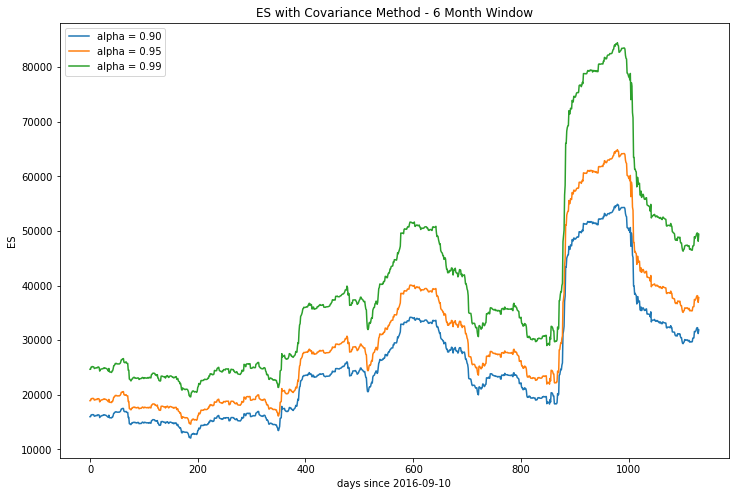

In [21]:
plt.figure(figsize=(12,8))
plt.plot(var_covar_half[0])
plt.plot(var_covar_half[1])
plt.plot(var_covar_half[2])
plt.legend(legends)
plt.title('VaR with Covariance Method - 6 Month Window')
plt.xlabel('days since 2016-09-10')
plt.ylabel('VaR')
# plt.savefig('VaR with Covariance Method 6 Month Window.png')
plt.show()


plt.figure(figsize=(12,8))
plt.plot(es_covar_half[0])
plt.plot(es_covar_half[1])
plt.plot(es_covar_half[2])
plt.legend(legends)
plt.title('ES with Covariance Method - 6 Month Window')
plt.xlabel('days since 2016-09-10')
plt.ylabel('ES')
plt.savefig('ES with Covariance Method 6 Month Window.png')
plt.show()


In [22]:
#var covar results

window = round(252*2)
var_covar_double,es_covar_double =[[],[],[]],[[],[],[]]


for i in range(3):
    for horizon in range (log_returns.shape[1]-window):
        sample = log_returns[:,horizon:horizon+window]
        var,es = varcovar_method(sample,weights, investment, confidence[i])
        var_covar_double[i].append(var)
        es_covar_double[i].append(es)
    var_covar_double[i].reverse()
    es_covar_double[i].reverse()
    


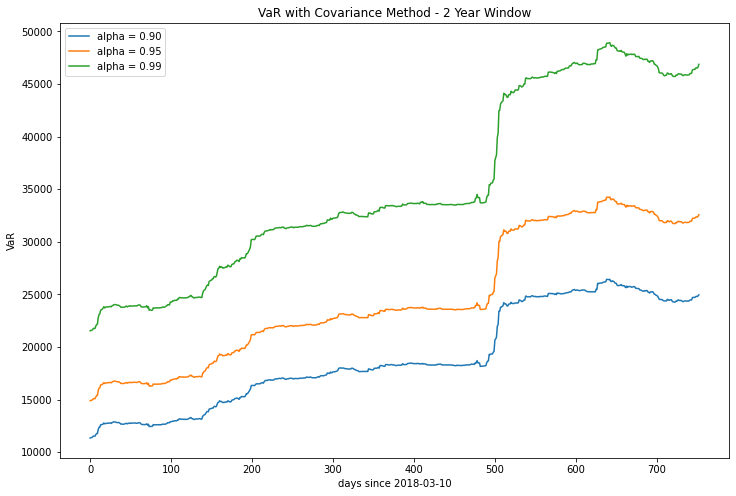

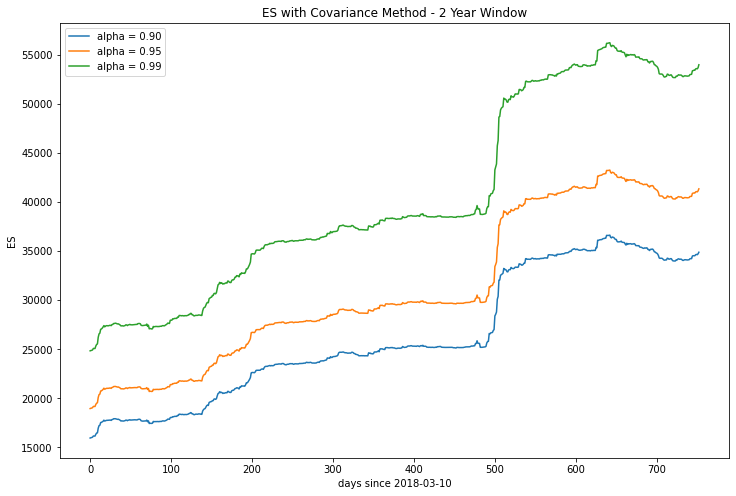

In [23]:
plt.figure(figsize=(12,8))
plt.plot(var_covar_double[0])
plt.plot(var_covar_double[1])
plt.plot(var_covar_double[2])
plt.legend(legends)
plt.title('VaR with Covariance Method - 2 Year Window')
plt.xlabel('days since 2018-03-10')
plt.ylabel('VaR')
# plt.savefig('VaR with Covariance Method 2 Month Window.png')
plt.show()


plt.figure(figsize=(12,8))
plt.plot(es_covar_double[0])
plt.plot(es_covar_double[1])
plt.plot(es_covar_double[2])
plt.legend(legends)
plt.title('ES with Covariance Method - 2 Year Window')
plt.xlabel('days since 2018-03-10')
plt.ylabel('ES')
# plt.savefig('ES with Covariance Method 2 Month Window.png')
plt.show()


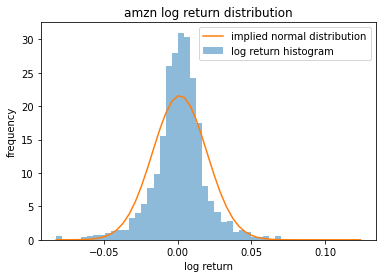

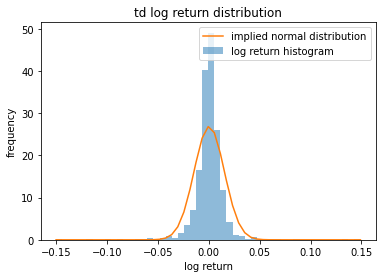

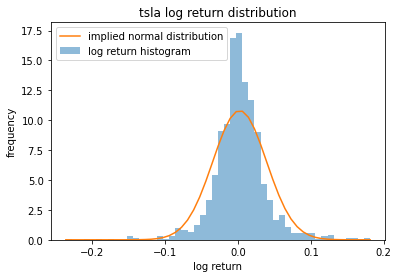

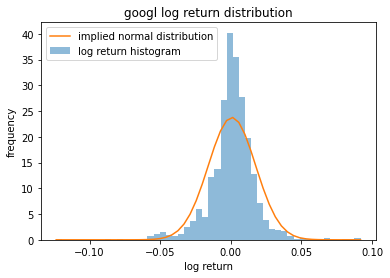

In [24]:
stocks = ['amzn', 'td', 'tsla', 'googl']
v = investment
i = 0
for stock in log_returns:
    _, bins, _ = plt.hist(stock, 50, density=1, alpha=0.5)
    mu, sigma = norm.fit(stock)
    best_fit_line = norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    plt.legend(['implied normal distribution','log return histogram'])
    plt.title('{} log return distribution'.format(stocks[i]))
    plt.xlabel('log return')
    plt.ylabel('frequency')
#     plt.savefig('{} log return distribution.png'.format(stocks[i]))
    plt.show()
    i+=1
    